In [1]:
!git clone https://github.com/YuZhang-GitHub/Codebook_Learning_RL.git

Cloning into 'Codebook_Learning_RL'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 77 (delta 5), reused 0 (delta 0), pack-reused 59
Receiving objects: 100% (77/77), 14.41 MiB | 37.46 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [2]:
import os
os.chdir('/kaggle/working/Codebook_Learning_RL')
print(os.getcwd())

/kaggle/working/Codebook_Learning_RL


In [3]:
import os
import time
import torch
import numpy as np
import copy
import pickle
from scipy.optimize import linear_sum_assignment
from DataPrep import dataPrep
from env_ddpg import envCB
from clustering import KMeans_only
from function_lib import bf_gain_cal, corr_mining
from DDPG_classes import Actor, Critic, OUNoise, init_weights

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
class envCB_(envCB):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gain_history = [0]
        self.EGC_history = []
    def compute_EGC(self):
        ch_r = torch.Tensor.cpu(self.ch.clone()).numpy()[:, :self.num_ant]
        ch_i = torch.Tensor.cpu(self.ch.clone()).numpy()[:, self.num_ant:]
        radius = np.sqrt(np.square(ch_r) + np.square(ch_i))
        gain_opt = np.mean(np.square(np.sum(radius, axis=1)))
        return gain_opt

In [5]:
# new_gain = torch.Tensor.cpu(CB_Env.achievement).detach().numpy().reshape((1, 1))
# max_previous_gain = max(CB_Env.gain_history)
#         if new_gain > max_previous_gain:
#             CB_Env.gain_history.append(float(new_gain))                   
#         else:
#             CB_Env.gain_history.append(float(max_previous_gain))

In [6]:
options = {
        'gpu_idx': 0,
        'num_ant': 32,
        'num_bits': 4,
        'num_NNs': 4,  # codebook size
        'ch_sample_ratio': 0.5,
        'num_loop': 400,  # outer loop
        'target_update': 3,
        'path': './grid1101-1400.mat',
        'clustering_mode': 'random',
    }

train_opt = {
        'state': 0,
        'best_state': 0,
        'num_iter': 100,  # inner loop
        'tau': 1e-2,
        'overall_iter': 1,
        'replay_memory': [],
        'replay_memory_size': 8192,
        'minibatch_size': 1024,
        'gamma': 0
    }
if not os.path.exists('beams/'):
    os.mkdir('beams/')

ch = dataPrep(options['path'])
ch = np.concatenate((ch[:, :options['num_ant']],
                     ch[:, int(ch.shape[1] / 2):int(ch.shape[1] / 2) + options['num_ant']]), axis=1)


In [7]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

def train(actor_net,
          critic_net,
          actor_net_t,
          critic_net_t,
          ounoise,
          env,
          options,
          train_options,
          beam_id):
    CB_Env = env
    critic_optimizer = optim.Adam(critic_net.parameters(), lr=1e-3, weight_decay=1e-3)
    actor_optimizer = optim.Adam(actor_net.parameters(), lr=1e-3, weight_decay=1e-2)
    critic_criterion = nn.MSELoss()

    if train_options['overall_iter'] == 1:
        state = torch.zeros((1, options['num_ant'])).float().cuda()
        print('Initial State Activated.')
    else:
        state = train_options['state']

    # -------------- Training -------------- #
    replay_memory = train_options['replay_memory']
    iteration = 0
    num_of_iter = train_options['num_iter']
    while iteration < num_of_iter:

        # Proto-action
        action_pred = actor_net(state)
        reward_pred, bf_gain_pred, action_quant_pred, state_1_pred = CB_Env.get_reward(action_pred)
        reward_pred = torch.from_numpy(reward_pred).float().cuda()

        # Exploration and Quantization Processing
        action_pred_noisy = ounoise.get_action(action_pred,
                                               t=train_options['overall_iter'])  # torch.Size([1, action_dim])
        mat_dist = torch.abs(action_pred_noisy.reshape(options['num_ant'], 1) - options['ph_table_rep'])
        action_quant = options['ph_table_rep'][range(options['num_ant']), torch.argmin(mat_dist, dim=1)].reshape(1, -1)

        state_1, reward, bf_gain, terminal = CB_Env.step(action_quant)
        reward = torch.from_numpy(reward).float().cuda()
        action = action_quant.reshape((1, -1)).float().cuda()
        
        new_gain = torch.Tensor.cpu(CB_Env.achievement).detach().numpy().reshape((1, 1))
        max_previous_gain = max(CB_Env.gain_record)
        if new_gain > max_previous_gain:
            CB_Env.gain_history.append(float(new_gain))                   
        else:
            CB_Env.gain_history.append(float(max_previous_gain))
            
        replay_memory.append((state, action, reward, state_1, terminal))
        replay_memory.append((state, action_quant_pred, reward_pred, state_1_pred, terminal))
        while len(replay_memory) > train_options['replay_memory_size']:
            replay_memory.pop(0)

        # -------------- Experience Replay -------------- #
        minibatch = random.sample(replay_memory, min(len(replay_memory), train_options['minibatch_size']))

        state_batch = torch.cat(tuple(d[0] for d in minibatch))  # torch.Size([*, state_dim])
        action_batch = torch.cat(tuple(d[1] for d in minibatch))  # torch.Size([*, action_dim])
        reward_batch = torch.cat(tuple(d[2] for d in minibatch))  # torch.Size([*, 1])
        state_1_batch = torch.cat(tuple(d[3] for d in minibatch))  # torch.Size([*, state_dim])

        state_batch = state_batch.detach()
        action_batch = action_batch.detach()
        reward_batch = reward_batch.detach()
        state_1_batch = state_1_batch.detach()

        if torch.cuda.is_available():
            state_batch = state_batch.cuda()
            action_batch = action_batch.cuda()
            reward_batch = reward_batch.cuda()
            state_1_batch = state_1_batch.cuda()

        # Loss Calculation for Critic Network
        next_actions = actor_net_t(state_1_batch)
        next_Q = critic_net_t(state_1_batch, next_actions)
        Q_prime = reward_batch + train_options['gamma'] * next_Q
        Q_pred = critic_net(state_batch, action_batch)
        critic_loss = critic_criterion(Q_pred, Q_prime.detach())

        # Update Critic Network
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Loss Calculation for Actor Network
        actor_loss = torch.mean(-critic_net(state_batch, actor_net(state_batch)))

        # Update Actor Network
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # UPDATE state, epsilon, target network, etc.
        state = state_1
        iteration += 1
        train_options['overall_iter'] += 1  # global counter

        # Update: Target Network
        if train_options['overall_iter'] % options['target_update'] == 0:
            actor_params = actor_net.state_dict()
            critic_params = critic_net.state_dict()
            actor_t_params = actor_net_t.state_dict()
            critic_t_params = critic_net_t.state_dict()

            for name in critic_params:
                critic_params[name] = train_options['tau'] * critic_params[name].clone() + \
                                      (1 - train_options['tau']) * critic_t_params[name].clone()

            critic_net_t.load_state_dict(critic_params)

            for name in actor_params:
                actor_params[name] = train_options['tau'] * actor_params[name].clone() + \
                                     (1 - train_options['tau']) * actor_t_params[name].clone()

            actor_net_t.load_state_dict(actor_params)

            # actor_net_t.load_state_dict(actor_net.state_dict())
            # critic_net_t.load_state_dict(critic_net.state_dict())

    if (train_options['overall_iter']-1)%500==0:
        print(
            "Beam: %d, Iter: %d, Q: %.4f, Reward pred: %d, Reward: %d, BF Gain pred: %.2f, BF Gain: %.2f, Critic Loss: %.2f, Policy Loss: %.2f" % \
            (beam_id, train_options['overall_iter'],
             np.max(torch.Tensor.cpu(Q_pred.detach()).numpy().squeeze()),
             int(torch.Tensor.cpu(reward_pred).numpy().squeeze()),
             int(torch.Tensor.cpu(reward).numpy().squeeze()),
             torch.Tensor.cpu(bf_gain_pred.detach()).numpy().squeeze(),
             torch.Tensor.cpu(bf_gain.detach()).numpy().squeeze(),
             torch.Tensor.cpu(critic_loss.detach()).numpy().squeeze(),
             torch.Tensor.cpu(actor_loss.detach()).numpy().squeeze()))

    # Training Communication Interface
    train_options['replay_memory'] = replay_memory  # used for the next loop
    train_options['state'] = state  # used for the next loop
    train_options['best_state'] = CB_Env.best_bf_vec  # used for clustering and assignment

    return train_options

In [8]:
with torch.cuda.device(options['gpu_idx']):
    u_classifier, sensing_beam = KMeans_only(ch, options['num_NNs'], n_bit=options['num_bits'], n_rand_beam=30)
    np.save('sensing_beam.npy', sensing_beam)
    sensing_beam = torch.from_numpy(sensing_beam).float().cuda()

    filename = 'kmeans_model.sav'
    pickle.dump(u_classifier, open(filename, 'wb'))

    # Quantization settings
    options['num_ph'] = 2 ** options['num_bits']
    options['multi_step'] = torch.from_numpy(
        np.linspace(int(-(options['num_ph'] - 2) / 2),
                    int(options['num_ph'] / 2),
                    num=options['num_ph'],
                    endpoint=True)).type(dtype=torch.float32).reshape(1, -1).cuda()
    options['pi'] = torch.tensor(np.pi).cuda()
    options['ph_table'] = (2 * options['pi']) / options['num_ph'] * options['multi_step']
    options['ph_table'].cuda()
    options['ph_table_rep'] = options['ph_table'].repeat(options['num_ant'], 1)

    # initialize DRL models
    actor_net_list = []
    critic_net_list = []
    actor_net_t_list = []
    critic_net_t_list = []
    ounoise_list = []
    env_list = []
    train_opt_list = []

    for beam_id in range(options['num_NNs']):
        actor_net_list.append(Actor(options['num_ant'], options['num_ant']))
        actor_net_t_list.append(Actor(options['num_ant'], options['num_ant']))
        critic_net_list.append(Critic(2 * options['num_ant'], 1))
        critic_net_t_list.append(Critic(2 * options['num_ant'], 1))
        ounoise_list.append(OUNoise((1, options['num_ant'])))
        env_list.append(envCB_(ch, options['num_ant'], options['num_bits'], beam_id, options))
        train_opt_list.append(copy.deepcopy(train_opt))

        actor_net_list[beam_id] = actor_net_list[beam_id].cuda()
        actor_net_t_list[beam_id] = actor_net_t_list[beam_id].cuda()
        critic_net_list[beam_id] = critic_net_list[beam_id].cuda()
        critic_net_t_list[beam_id] = critic_net_t_list[beam_id].cuda()
        actor_net_list[beam_id].apply(init_weights)
        actor_net_t_list[beam_id].load_state_dict(actor_net_list[beam_id].state_dict())
        critic_net_list[beam_id].apply(init_weights)
        critic_net_t_list[beam_id].load_state_dict(critic_net_list[beam_id].state_dict())

    # start_time = time.time()

    # outer loop for randomly sampling users, emulating user dynamics
    for sample_id in range(options['num_loop']):

        # ---------- Sampling ---------- #
        n_sample = int(ch.shape[0] * options['ch_sample_ratio'])
        ch_sample_id = np.random.permutation(ch.shape[0])[0:n_sample]
        ch_sample = torch.from_numpy(ch[ch_sample_id, :]).float().cuda()

        # ---------- Clustering ---------- #
#         start_time = time.time()

        bf_mat_sample = bf_gain_cal(sensing_beam, ch_sample)
        # print("Clustering -1 uses %s seconds." % (time.time() - start_time))
        # start_time = time.time()
        f_matrix = corr_mining(bf_mat_sample)
        f_matrix_np = torch.Tensor.cpu(f_matrix).numpy()
        # print("Clustering 0 uses %s seconds." % (time.time() - start_time))
        # start_time = time.time()
        labels = u_classifier.predict(np.transpose(f_matrix_np).astype(float))

        # print("Clustering 1 uses %s seconds." % (time.time() - start_time))
        # start_time = time.time()

        user_group = []  # order: clusters
        ch_group = []  # order: clusters
        for ii in range(options['num_NNs']):
            user_group.append(np.where(labels == ii)[0].tolist())
            ch_group.append(ch_sample[user_group[ii], :])

#         print("Clustering 2 uses %s seconds." % (time.time() - start_time))

        # ---------- Assignment ---------- #
#         start_time = time.time()

        # best_state matrix
        best_beam_mtx = torch.zeros((options['num_NNs'], 2 * options['num_ant'])).float().cuda()
        for pp in range(options['num_NNs']):
            best_beam_mtx[pp, :] = env_list[pp].best_bf_vec
        gain_mtx = bf_gain_cal(best_beam_mtx, ch_sample)  # (n_beam, n_user)
        for ii in range(options['num_NNs']):
            if ii == 0:
                cost_mtx = torch.mean(gain_mtx[:, user_group[ii]], dim=1).reshape(options['num_NNs'], -1)
            else:
                sub = torch.mean(gain_mtx[:, user_group[ii]], dim=1).reshape(options['num_NNs'], -1)
                cost_mtx = torch.cat((cost_mtx, sub), dim=1)
        cost_mtx = -torch.Tensor.cpu(cost_mtx).numpy()
        row_ind, col_ind = linear_sum_assignment(cost_mtx)
        assignment_record = dict(zip(row_ind.tolist(), col_ind.tolist()))  # key: network, value: cluster
#         print(assignment_record)
        for ii in range(options['num_NNs']):
            env_list[ii].ch = ch_group[assignment_record[ii]]
            env_list[ii].EGC_history.append(env_list[ii].compute_EGC())
#         print("Assignment uses %s seconds." % (time.time() - start_time))
        if (train_opt_list[beam_id]['overall_iter']-1)%500==0 or train_opt_list[beam_id]['overall_iter']==1:
            start_time = time.time()
        # ---------- Learning ---------- #
        for beam_id in range(options['num_NNs']):
            train_opt_list[beam_id] = train(actor_net_list[beam_id],
                                            critic_net_list[beam_id],
                                            actor_net_t_list[beam_id],
                                            critic_net_t_list[beam_id],
                                            ounoise_list[beam_id],
                                            env_list[beam_id],
                                            options,
                                            train_opt_list[beam_id],
                                            beam_id)
        if (train_opt_list[beam_id]['overall_iter']-1)%500==0: 
            print("Training for 500 iteration for each Beam uses %s seconds." % (time.time() - start_time))

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


EGC bf gain:  231.17094
EGC bf gain:  231.17094
EGC bf gain:  231.17094
EGC bf gain:  231.17094
Initial State Activated.
Initial State Activated.
Initial State Activated.
Initial State Activated.
Beam: 0, Iter: 501, Q: 1.5792, Reward pred: 1, Reward: 1, BF Gain pred: 2.41, BF Gain: 8.80, Critic Loss: 0.30, Policy Loss: -2.28
Beam: 1, Iter: 501, Q: 1.5097, Reward pred: 1, Reward: 1, BF Gain pred: 1.42, BF Gain: 9.48, Critic Loss: 0.28, Policy Loss: -2.21
Beam: 2, Iter: 501, Q: 1.9630, Reward pred: 1, Reward: -1, BF Gain pred: 26.63, BF Gain: 16.88, Critic Loss: 0.27, Policy Loss: -3.09
Beam: 3, Iter: 501, Q: 1.4151, Reward pred: -1, Reward: -1, BF Gain pred: 6.20, BF Gain: 7.71, Critic Loss: 0.23, Policy Loss: -2.32
Training for 500 iteration for each Beam uses 21.835363388061523 seconds.
Beam: 0, Iter: 1001, Q: 1.5502, Reward pred: 1, Reward: 1, BF Gain pred: 2.01, BF Gain: 5.28, Critic Loss: 0.14, Policy Loss: -1.93
Beam: 1, Iter: 1001, Q: 1.6157, Reward pred: -1, Reward: -1, BF Gain 

In [9]:
import numpy as np
import scipy.io as scio

num_ant = 32
num_beam = 4
results = np.empty((num_beam, 2*num_ant))

path = './beams/'

for beam_id in range(num_beam):
    fname = 'beams_' + str(beam_id) + '_max.txt'
    with open(path + fname, 'r') as f:
        lines = f.readlines()
        last_line = lines[-1]
        results[beam_id, :] = np.fromstring(last_line.replace("\n", ""), sep=',').reshape(1, -1)

results = (1 / np.sqrt(num_ant)) * (results[:, ::2] + 1j * results[:, 1::2])

scio.savemat('beam_codebook.mat', {'beams': results})

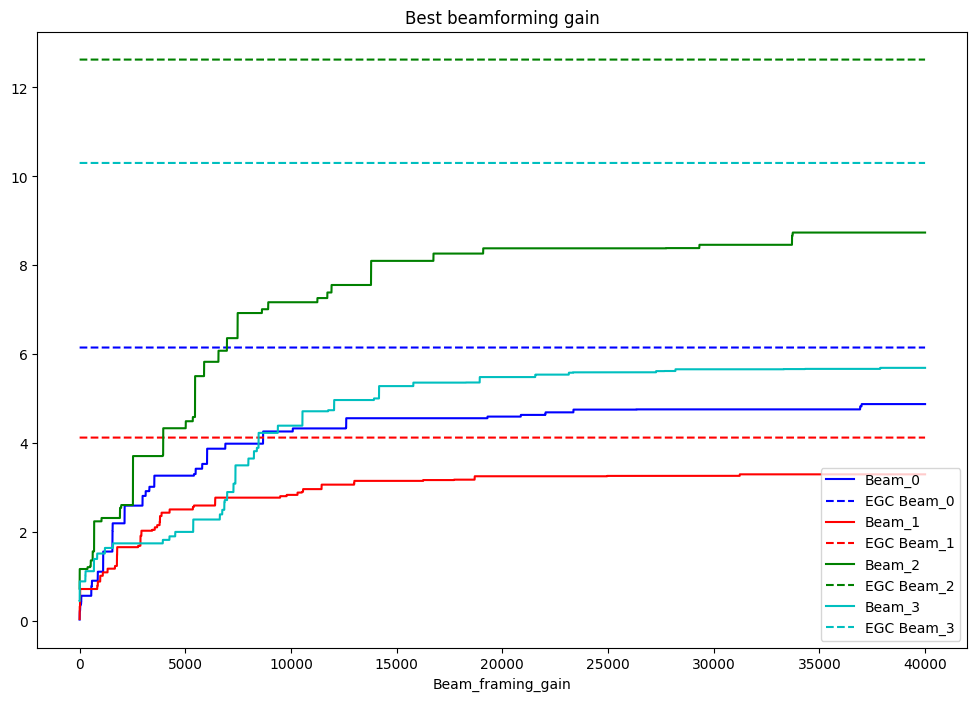

In [10]:
from matplotlib import pyplot as plt
colors = ['b','r','g','c']
plt.figure(figsize=(12, 8))
plt.title(f'Best beamforming gain')
plt.xlabel('Beam_framing_gain')   
for beam_id, color in enumerate(colors):
    gain_record = np.array(env_list[beam_id].gain_history[1:])/options['num_ant']
    np.save(f'beam_{beam_id}_gain_records',gain_record)
    plt.plot(gain_record, label=f'Beam_{beam_id}',color=color)
    EGC = env_list[beam_id].compute_EGC()/options['num_ant']
    
    n_iterations = options['num_loop']*train_opt['num_iter']
    plt.plot([EGC]*n_iterations,linestyle='dashed',color=color,label=f'EGC Beam_{beam_id}')
plt.legend(loc="lower right")  
plt.show()    

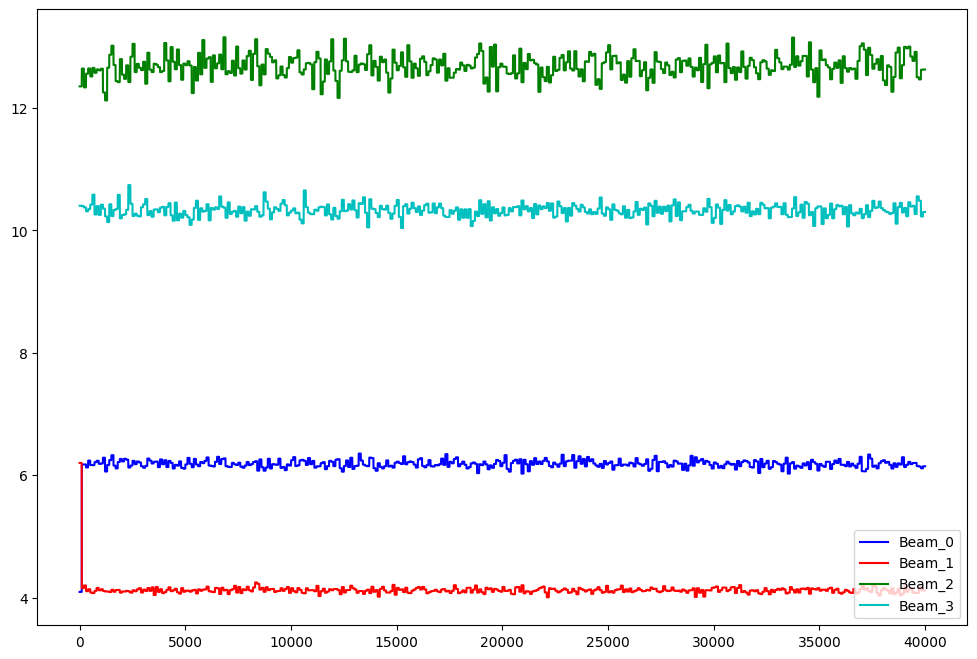

In [11]:
def duplicate_n_times(lst, n):
    duplicated_list = []
    for item in lst:
        duplicated_list.extend([item] * n)
    return duplicated_list
plt.figure(figsize=(12, 8))
for beam_id, color in enumerate(colors):
    egc = duplicate_n_times(env_list[beam_id].EGC_history,100)
    egc=np.array(egc)/options['num_ant']
    plt.plot(egc, label=f'Beam_{beam_id}',color=color)
plt.legend(loc="lower right")  
plt.show()    

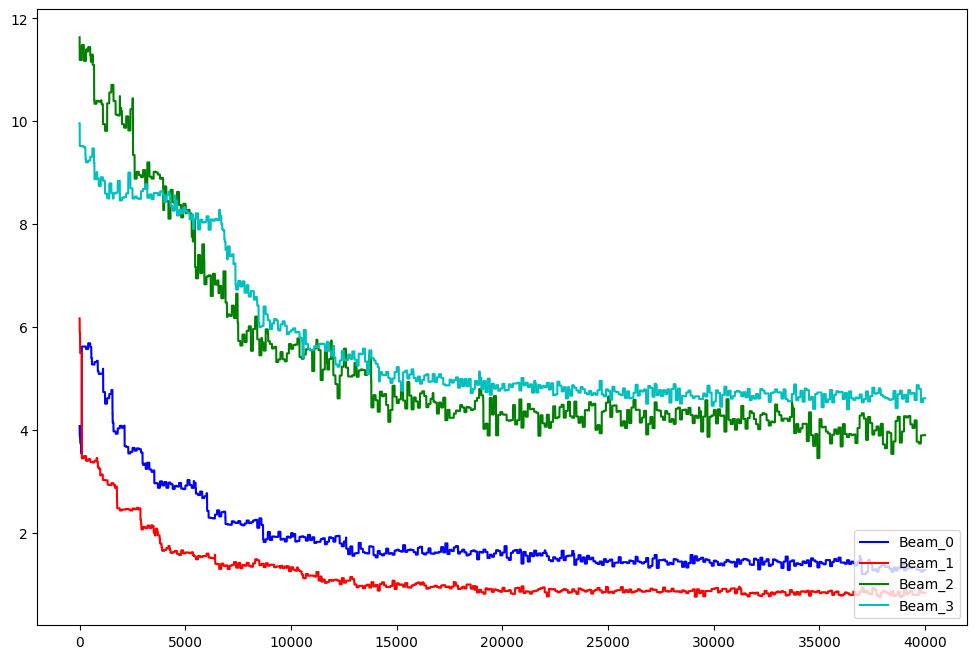

In [12]:
plt.figure(figsize=(12, 8))
for beam_id, color in enumerate(colors):
    n_iterations = options['num_loop']*train_opt['num_iter']
    egc = duplicate_n_times(env_list[beam_id].EGC_history,100)
    egc=np.array(egc)/options['num_ant']   
    gain_record = np.array(env_list[beam_id].gain_history[1:])/options['num_ant']
    plt.plot(egc-gain_record, label=f'Beam_{beam_id}',color=color)
plt.legend(loc="lower right")  
plt.show()    

In [13]:
accuracy = 0
for beam_id in range(4):
    egc = duplicate_n_times(env_list[beam_id].EGC_history,100)
    egc=np.array(egc)/options['num_ant']  
    gain_record = np.array(env_list[beam_id].gain_history[1:])/options['num_ant']
    perc = (gain_record)/egc
    accuracy +=perc[-1]
    perc = round(perc[-1]*100)
    print(f'beam_{beam_id} reached {perc}% of EGC upperbound')
print(f'Mean EGC reached for all users {round(accuracy*100/4)} %')

beam_0 reached 79% of EGC upperbound
beam_1 reached 80% of EGC upperbound
beam_2 reached 69% of EGC upperbound
beam_3 reached 55% of EGC upperbound
Mean EGC reached for all users 71 %
